In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import moviepy.editor as mp
from python_speech_features import mfcc, logfbank
from tqdm import tqdm
import scipy.signal
# import accelerometer_parameters as ap

audio_files_folder = '../audio/'
pickles_folder = '../cleaned_pickles/'
output = '../clean_filtered/'
image_output = '../sound/'

In [2]:
def get_audio(file):
    audio = mp.AudioFileClip(audio_files_folder+file)
    fps = audio.fps
    sound_array = audio.to_soundarray(nbytes=4, buffersize=1000, fps=fps)
    return fps,sound_array[:,0]

In [3]:
def segment(sound_array, fps, start_time, stop_time):
    start_idx = int(start_time*fps)
    stop_idx = int(stop_time*fps)
    return sound_array[start_idx:stop_idx]
    

In [4]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n,d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return Y, freq

In [5]:
def custom_bank(arr, rate, window = 0.25,step_t = 0.10, max_idx = 250):


    step = int(step_t*rate) # Number of points in step_t seconds
    n_rows = int(len(arr)/(step))-2
    w = int(window*rate)
    freq_array = []
    
    for r in range(n_rows):
        start = r*step
        stop = start + w
        
        clip = arr[start:stop]
        y,f = calc_fft(clip, rate)
        freq_array.append(y[:max_idx])
        
        
    
    return np.array(freq_array), f[:max_idx]

In [6]:
filenames = os.listdir(audio_files_folder)
print(filenames)

['03_02_2019_08_28_44.3gp', '03_02_2019_09_07_22.3gp', '03_02_2019_08_54_53.3gp', '03_02_2019_08_41_24.3gp', '03_01_2019_02_45_21.3gp', '03_02_2019_08_10_00.3gp', '03_01_2019_02_36_27.3gp']


In [7]:
def save_as_csv(dictionary, filename):
    with open(filename, 'w') as f:
        
        headers = list(dictionary.keys())
        
        for header in headers:
            f.write(header+',')
        f.write('\n')
        
        for i in range(len(dictionary[header])):
            for h in headers:
                f.write(str(dictionary[h][i])+',')
            f.write('\n')
            

In [8]:
def find_anomalies(audio_file, thresh = 0.2, window = .5,w2=0.25,graph=False):
    
    fps,sound_array = get_audio(audio_file) # get_audio() knows where to look
    cb, f = custom_bank(sound_array, fps)
    
    t_f = len(sound_array)/fps
    cb_sum = cb.sum(1)
    m = cb.mean(0)
    cb_above_thresh = np.multiply(cb_sum, cb_sum > thresh)
    
    cb_fps = len(cb_sum)/t_f
    t = t_f*np.arange(len(cb_sum))/len(cb_sum)
    peaks = scipy.signal.find_peaks(cb_above_thresh, distance = int(2*cb_fps/window))[0]
    
    if graph:
        plt.plot(t,cb_above_thresh)
        plt.scatter(t[peaks],cb_above_thresh[peaks],color='red')
        plt.xlim((0,100))
        plt.show()
    
    w = int(cb_fps*w2/2)
    freq_of_peaks = []
    t_of_peaks = t[peaks]
    for p in peaks:
        seg = cb[p-w:p+w]
        y = seg.mean(0)
#         y = y-m
        freq_of_peaks.append(y)
    
    if graph:
        for i in range(0,10,1):
            plt.plot(f,freq_of_peaks[i], linewidth=0.5)
    #     plt.plot(f,m)
        plt.xlim((50,400))
        plt.show()
    return freq_of_peaks, t_of_peaks, f

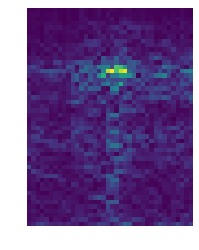

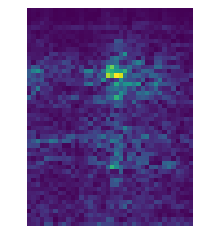

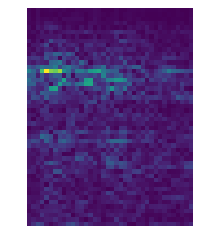

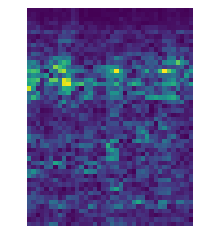

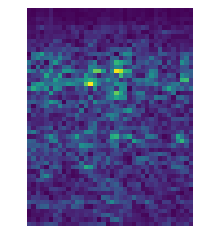

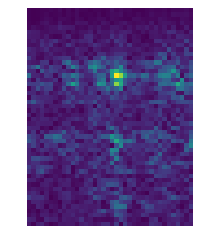

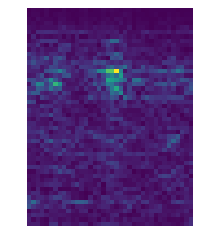

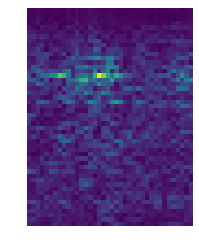

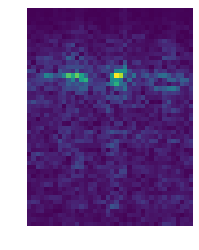

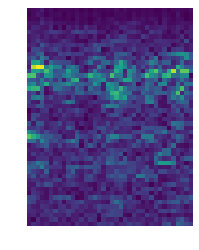

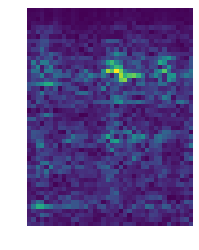

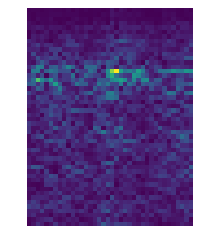

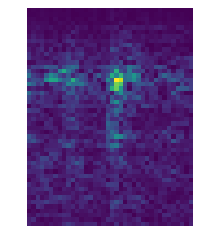

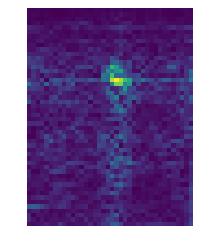

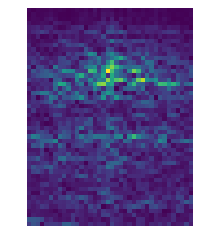

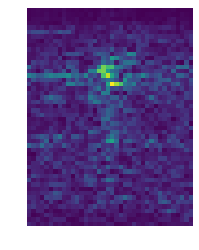

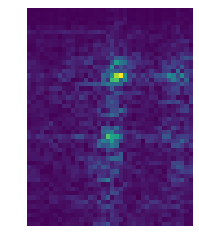

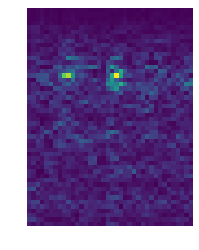

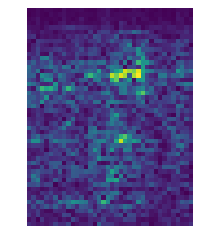

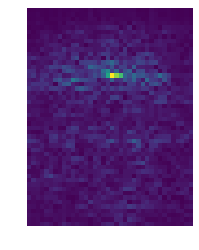

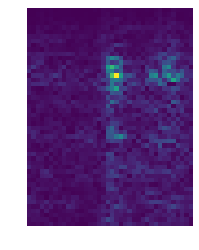

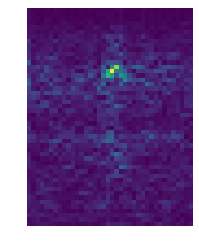

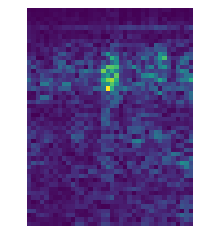

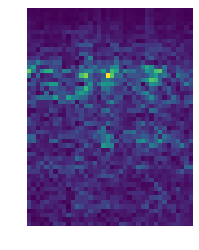

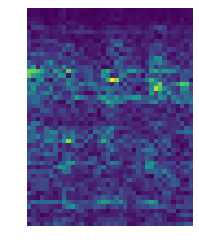

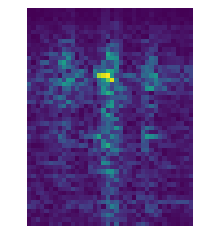

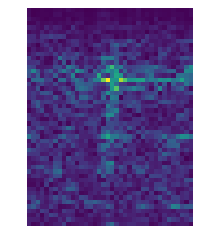

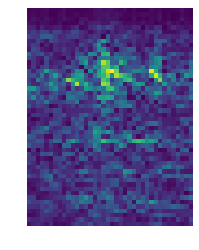

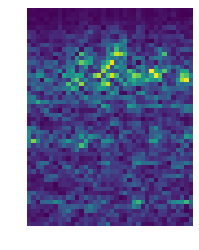

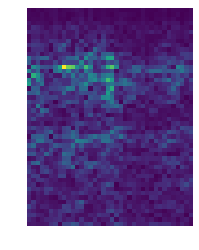

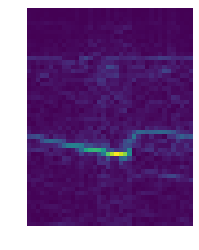

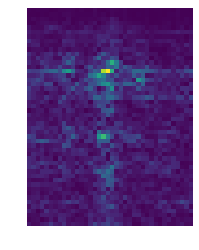

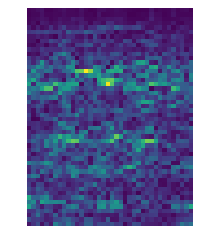

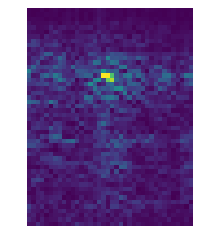

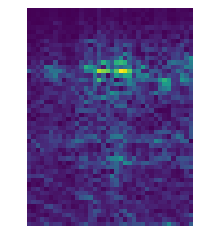

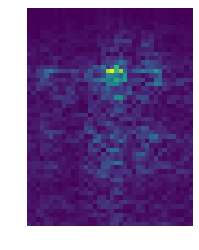

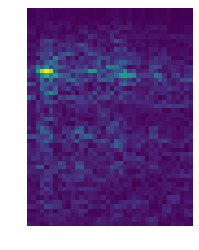

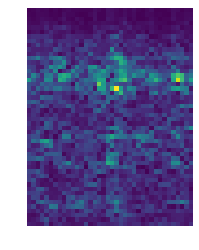

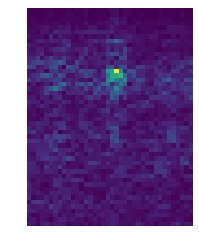

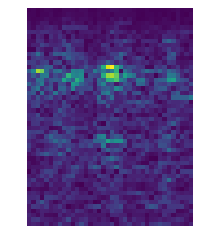

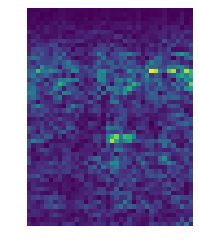

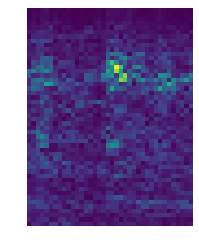

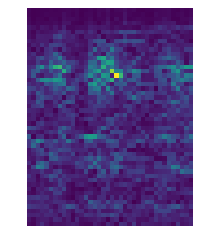

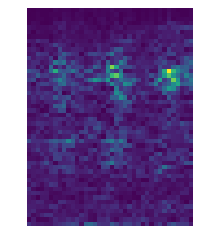

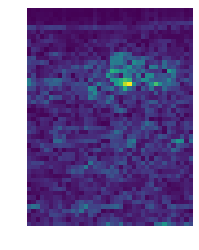

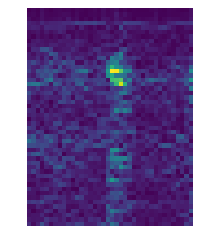

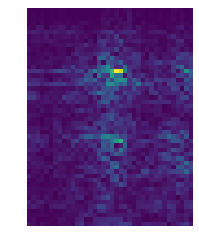

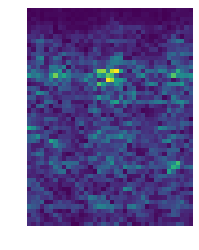

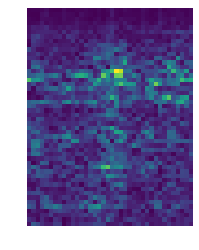

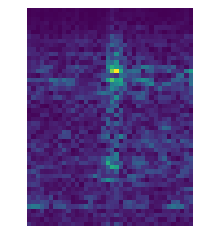

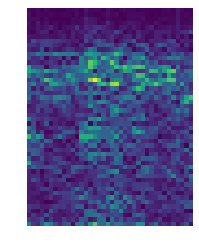

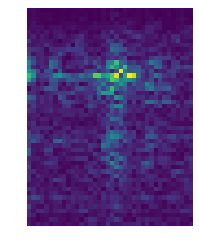

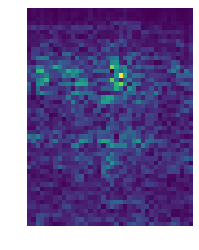

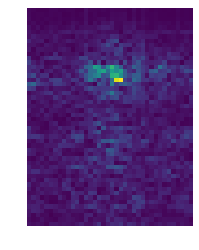

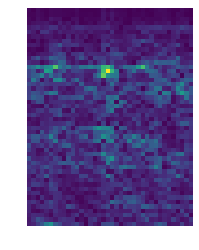

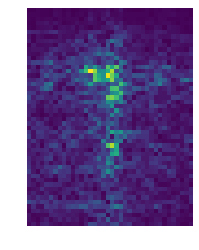

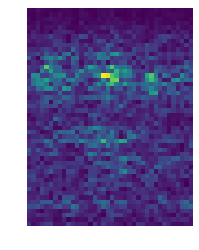

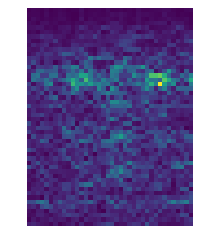

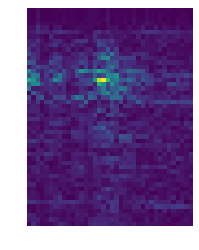

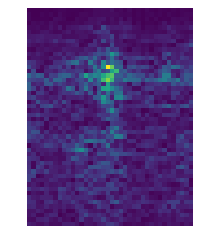

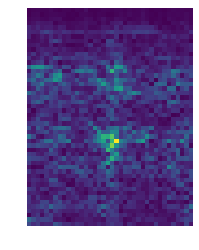

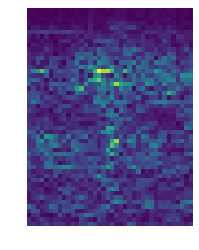

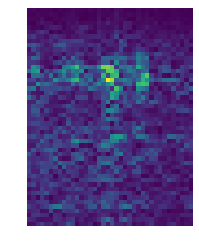

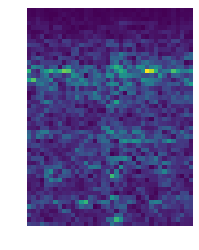

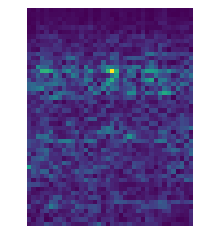

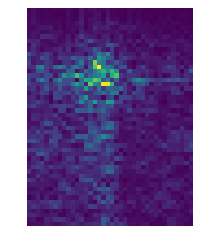

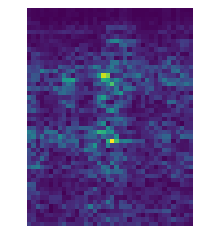

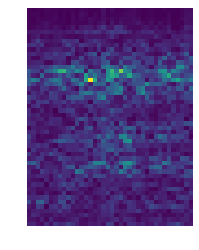

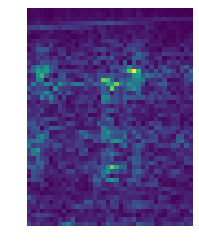

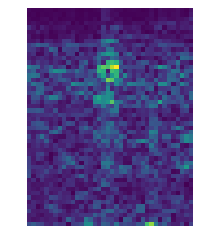

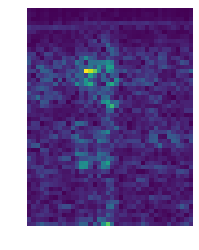

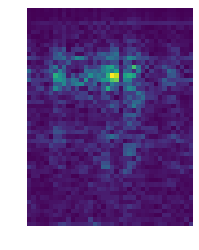

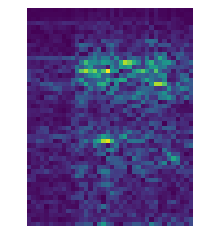

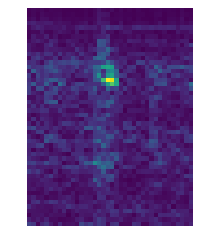

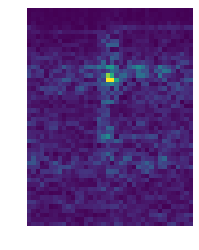

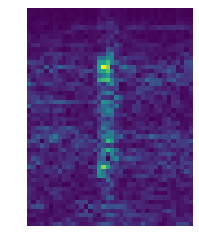

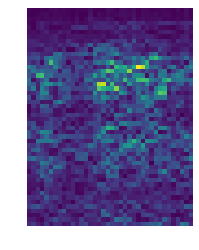

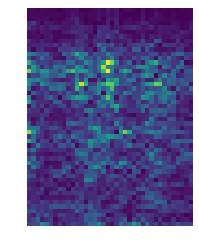

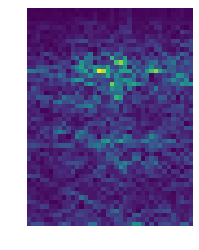

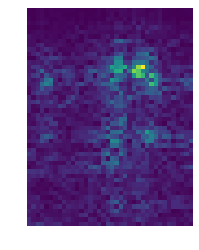

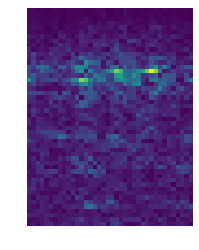

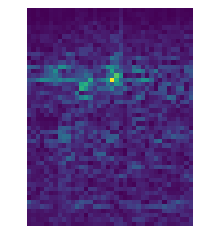

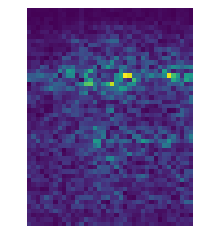

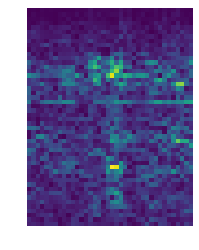

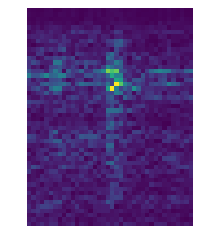

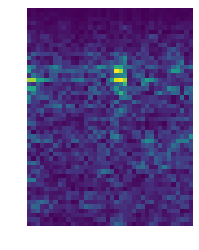

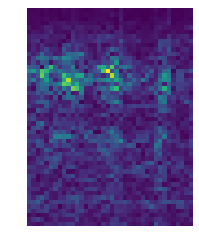

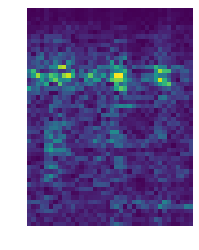

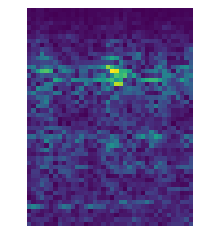

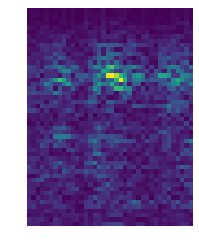

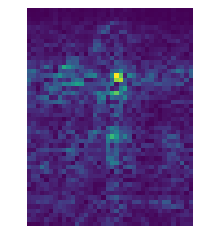

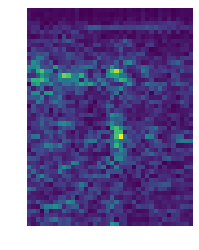

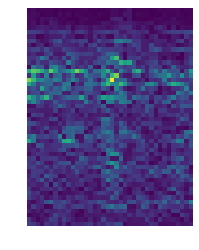

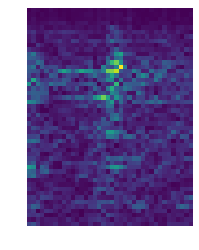

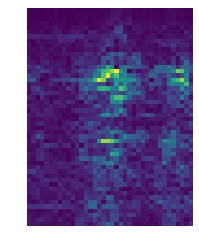

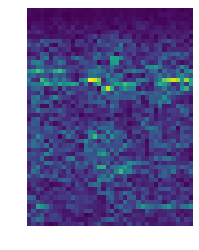

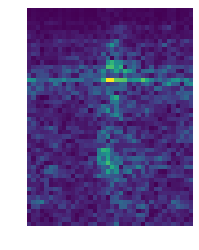

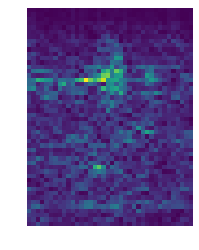

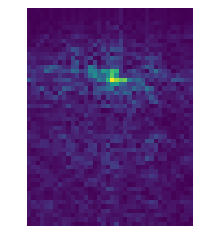

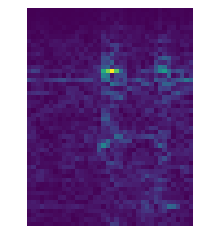

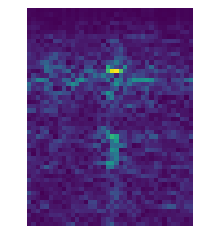

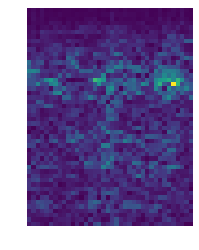

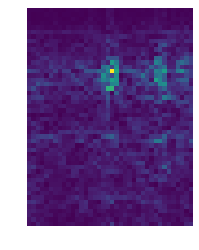

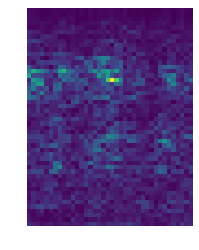

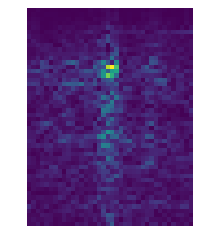

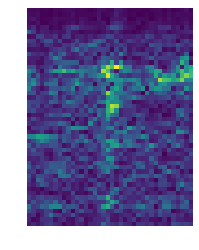

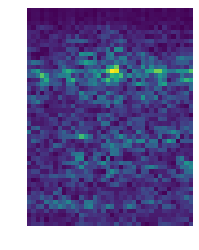

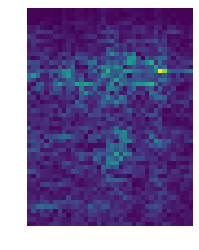

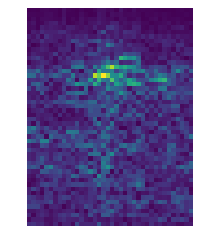

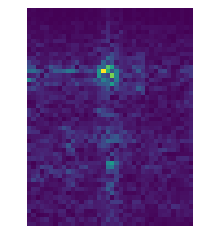

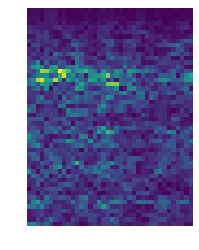

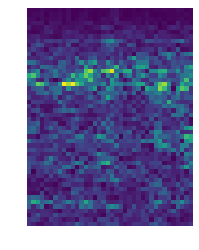

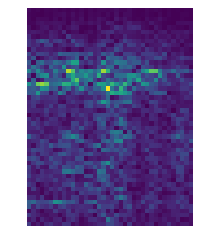

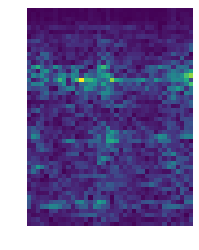

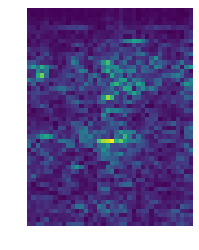

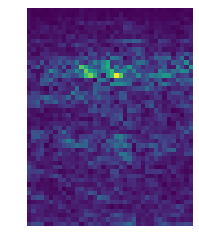

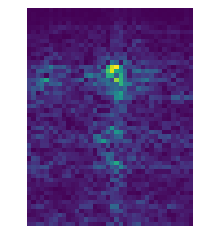

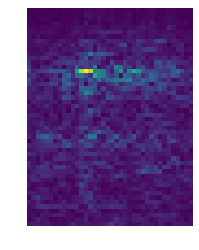

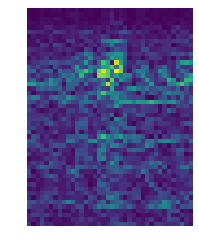

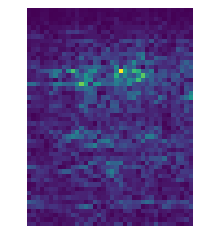

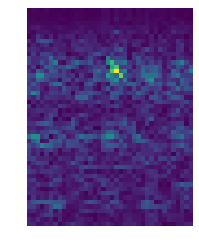

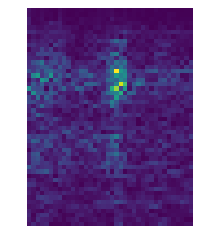

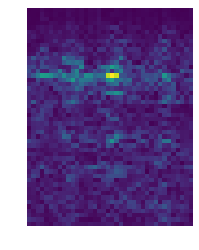

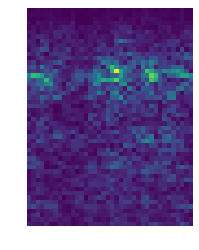

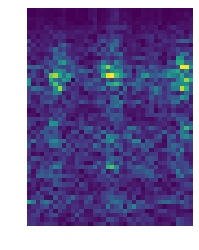

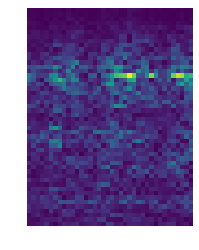

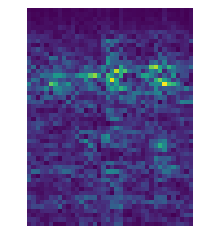

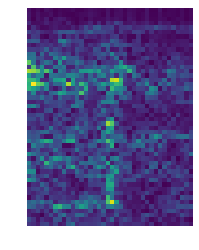

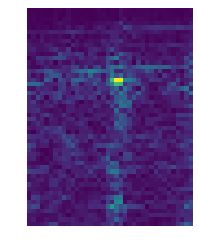

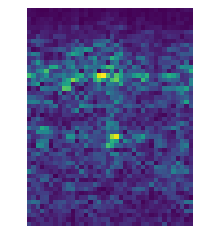

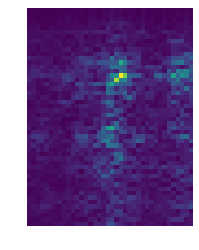

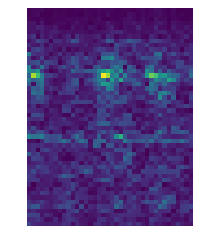

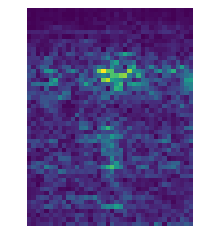

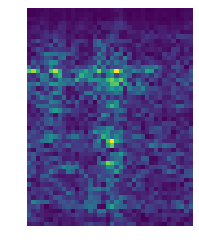

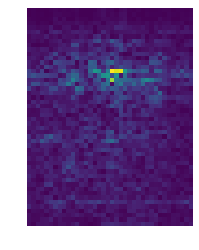

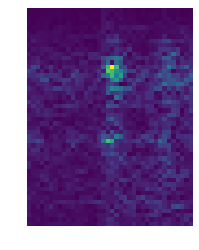

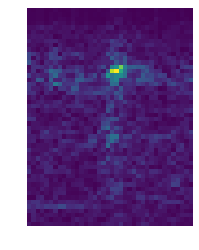

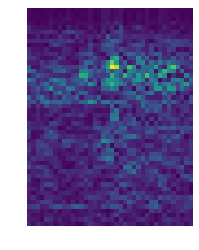

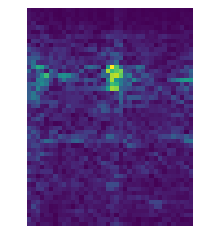

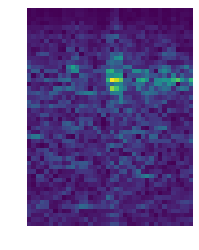

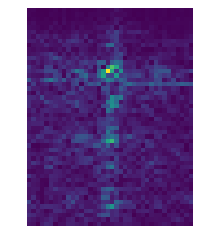

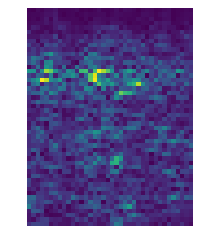

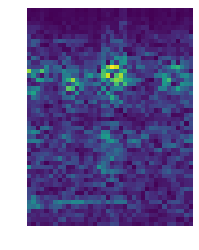

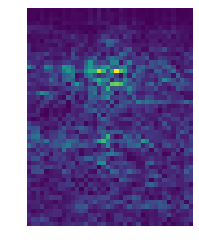

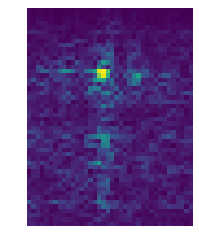

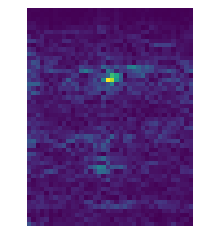

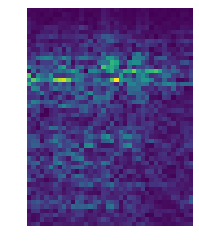

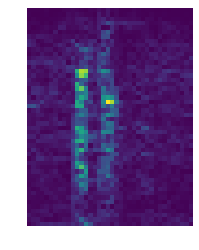

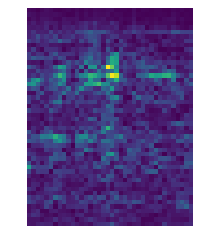

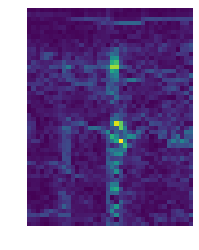

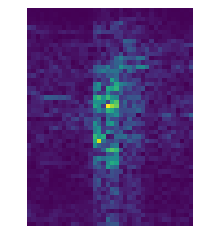

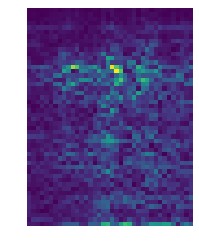

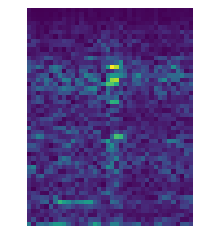

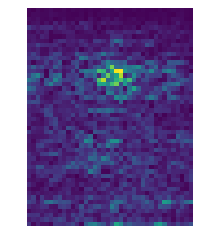

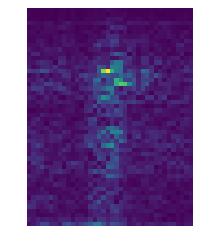

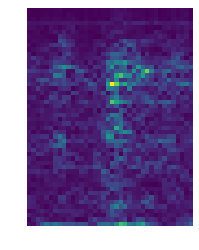

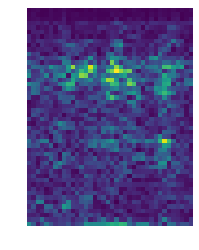

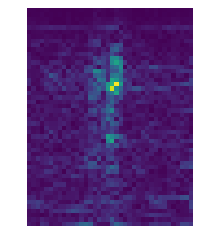

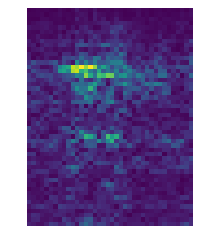

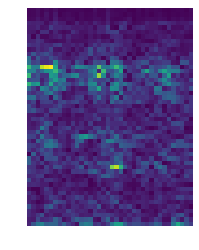

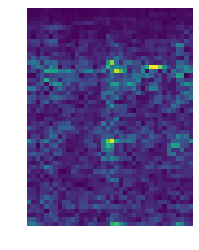

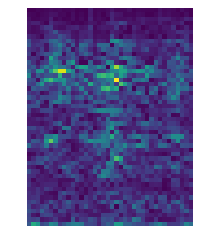

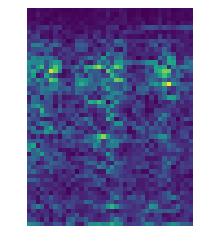

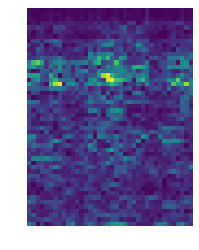

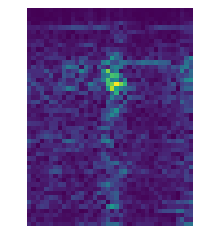

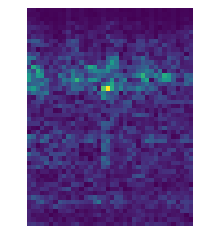

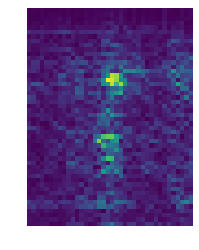

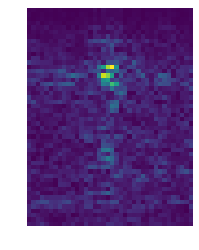

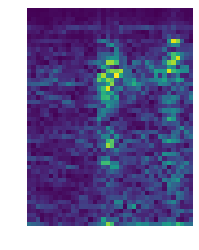

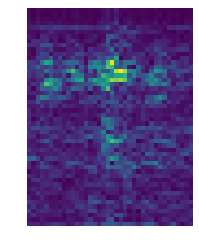

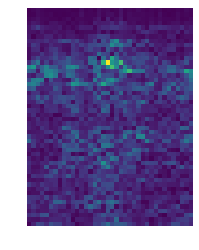

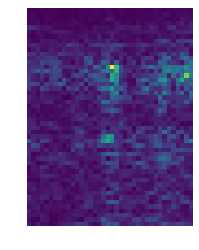

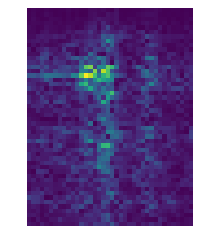

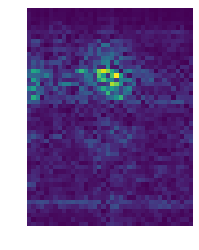

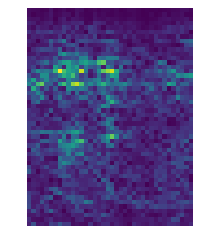

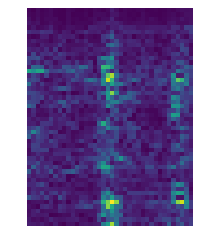

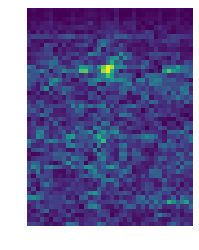

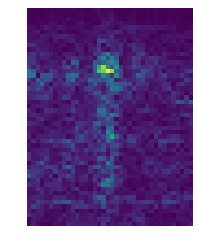

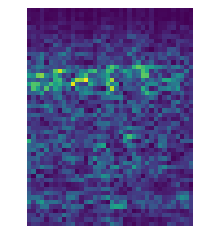

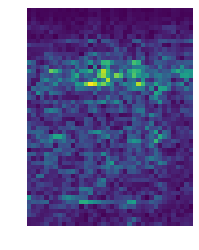

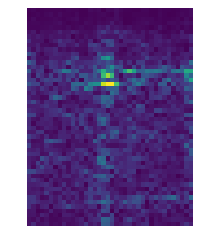

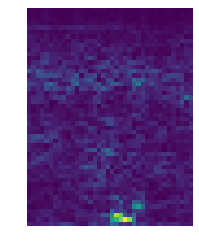

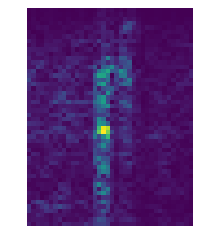

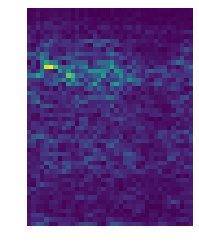

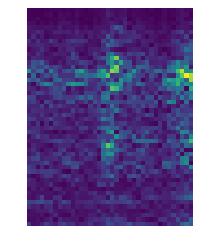

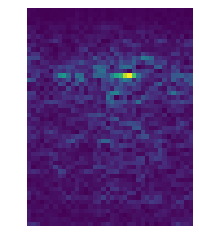

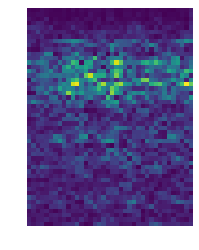

In [9]:
data = []
labels = []
for i in filenames:
    y,t,f = find_anomalies(i)
    fps,sound_array = get_audio(i)
    
    for j,k in enumerate(y):
#         print(t[j])
#         exit()
#         accel_data = ap.get_accel_data(audio_filename = i, time = t[j])
#         k = np.hstack((k,accel_data))
        data.append(k)
        name = i[:-4]+'__'+str(t[j])+'.png'
        labels.append(name)
        
        seg = segment(sound_array,fps,t[j]-2,t[j]+2)
        cb,f = custom_bank(seg,fps)
        cb = cb[:,10:60]
        cb = 255*cb/cb.max()
        plt.axis('off')
        plt.imshow(cb.T)
        plt.savefig('imgs/'+name, transparent=True, bbox_inches='tight', pad_inches=0)
        plt.show()
        
outfile = open('training_data.pkl','wb')
pickle.dump(data,outfile)
outfile.close()

outfile = open('labels.pkl','wb')
pickle.dump(labels,outfile)
outfile.close()


(187, 250)


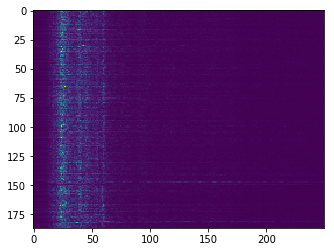

In [10]:
plt.imshow(data)
print(np.array(data).shape)

In [11]:
infile = open('labels.pkl','rb')
labels = pickle.load(infile)
infile.close()
print(labels[0])

03_02_2019_08_28_44__13.404948562384597.png


In [12]:
with open('labels.csv','w') as output:
    for label in labels:
        output.write(label+'\n')
    

In [13]:
print(labels[0])

03_02_2019_08_28_44__13.404948562384597.png


## Add Accelerometer data to the feature matrix

In [14]:
import accelerometer_parameters

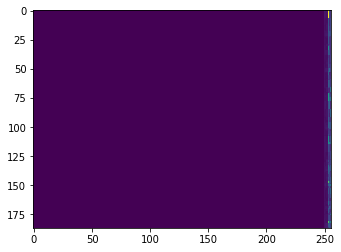

In [15]:
infile = open('training_data.pkl','rb')
training_data = pickle.load(infile)
infile.close()

plt.imshow(training_data)

The vertical line is the accelerometer data.
Clearly, in this case the scale of the accel_data is much larger than that of the frequency spectrum